# Ensemble Techinques
Combining multiple models to improve accuracy
1. Bagging - RandomForest (Parallel Trees are created)
2. Boosting - GradientBoost (Sequentially Corrective models are added)

In [2]:
from warnings import filterwarnings
filterwarnings("ignore")

## Step 1 - Read the dataset

In [3]:
import pandas as pd
df = pd.read_csv("train_titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Survived
1. 0 - NOT Survived
2. 1 - Survived

### Step 2 - Perform basic data quality checks

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
m = df.isna().sum()
m

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
m[m>0]

Age         177
Cabin       687
Embarked      2
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [10]:
df.nunique().sort_values(ascending=False)

PassengerId    891
Name           891
Ticket         681
Fare           248
Cabin          147
Age             88
SibSp            7
Parch            7
Embarked         3
Pclass           3
Survived         2
Sex              2
dtype: int64

### Step 3 - Seperate X and Y (Survived)
1. PassengerId - it is just serial number
2. Cabin - because of lots of missing values
3. Name - Dropping high cardinality
4. Ticket - High Cardinality

In [11]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [12]:
X = df.drop(columns=["PassengerId", "Cabin", "Name", "Ticket", "Survived"])
Y = df[["Survived"]]

In [13]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [14]:
Y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [15]:
Y.value_counts()

Survived
0           549
1           342
Name: count, dtype: int64

<Axes: xlabel='Survived'>

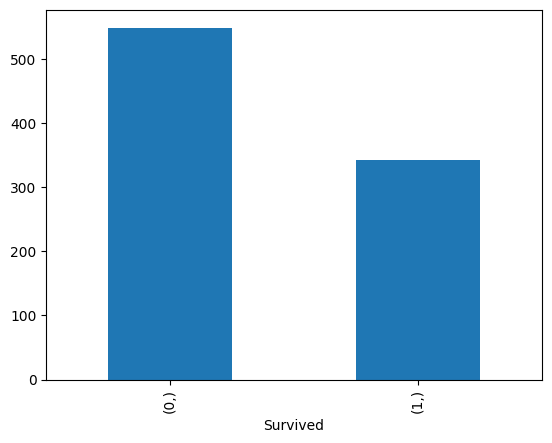

In [16]:
Y.value_counts().plot(kind="bar")

### Step 4 - Create preprocessing pipeline for X

In [17]:
X.dtypes

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [18]:
cat = list(X.columns[X.dtypes == "object"])
con = list(X.columns[X.dtypes != "object"])

In [19]:
cat

['Sex', 'Embarked']

In [20]:
con

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [22]:
num_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

In [23]:
cat_pipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)

In [24]:
pre = ColumnTransformer(
    [
        ("num", num_pipe, con),
        ("cat", cat_pipe, cat)
    ]
).set_output(transform="pandas")

In [25]:
X_pre = pre.fit_transform(X)
X_pre.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
0,0.827377,-0.565736,0.432793,-0.473674,-0.502445,0.0,1.0,0.0,0.0,1.0
1,-1.566107,0.663861,0.432793,-0.473674,0.786845,1.0,0.0,1.0,0.0,0.0
2,0.827377,-0.258337,-0.474545,-0.473674,-0.488854,1.0,0.0,0.0,0.0,1.0
3,-1.566107,0.433312,0.432793,-0.473674,0.420730,1.0,0.0,0.0,0.0,1.0
4,0.827377,0.433312,-0.474545,-0.473674,-0.486337,0.0,1.0,0.0,0.0,1.0


### Step 5 - Perform train test split

In [26]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(
    X_pre, Y, test_size=0.2, random_state=21
)

In [27]:
xtrain.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
793,-1.566107,-0.104637,-0.474545,-0.473674,-0.030371,0.0,1.0,1.0,0.0,0.0
23,-1.566107,-0.104637,-0.474545,-0.473674,0.066360,0.0,1.0,0.0,0.0,1.0
97,-1.566107,-0.488887,-0.474545,0.767630,0.627278,0.0,1.0,1.0,0.0,0.0
9,-0.369365,-1.180535,0.432793,-0.473674,-0.042956,1.0,0.0,1.0,0.0,0.0
157,0.827377,0.049062,-0.474545,-0.473674,-0.486337,0.0,1.0,0.0,0.0,1.0


In [28]:
ytrain.head()

,Survived
793,0
23,1
97,1
9,1
157,0


In [29]:
xtest.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
617,0.827377,-0.258337,0.432793,-0.473674,-0.324253,1.0,0.0,0.0,0.0,1.0
379,0.827377,-0.796286,-0.474545,-0.473674,-0.491874,0.0,1.0,0.0,0.0,1.0
725,0.827377,-0.719436,-0.474545,-0.473674,-0.474005,0.0,1.0,0.0,0.0,1.0
826,0.827377,-0.104637,-0.474545,-0.473674,0.489104,0.0,1.0,0.0,0.0,1.0
450,-0.369365,0.510161,0.432793,2.008933,-0.089684,0.0,1.0,0.0,0.0,1.0


In [30]:
ytest.head()

,Survived
617,0
379,0
725,0
826,0
450,0


In [31]:
xtrain.shape

(712, 10)

In [32]:
xtest.shape

(179, 10)

### Step 6: Model Building

### Random Forest
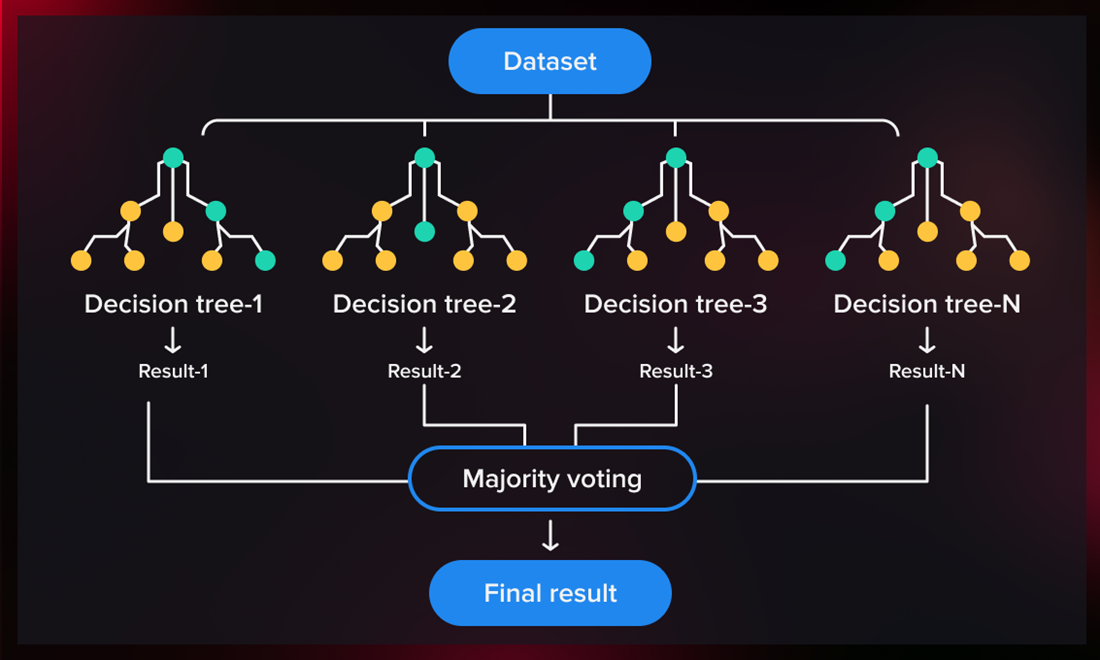

In [34]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(
    n_estimators=1,
    max_depth=1,
    min_samples_split=5,
    min_samples_leaf=5,
    criterion= "gini"
)
rfc.fit(xtrain, ytrain)

RandomForestClassifier(max_depth=1, min_samples_leaf=5, min_samples_split=5,
                       n_estimators=1)

In [35]:
rfc.score(xtrain, ytrain)

0.7879213483146067

In [36]:
rfc.score(xtest, ytest)

0.7821229050279329

### Tuning Randomforest

In [37]:
params1 = {
    "max_depth": [2, 3, 4, 5],
    "min_samples_split" : [5, 6, 7, 8],
    "criterion": ["gini", "entropy"]
}

### Randomised search cv is faster than gridsearch

In [38]:
from sklearn.model_selection import RandomizedSearchCV

In [40]:
model1 = RandomForestClassifier()
rscv1 = RandomizedSearchCV(
    estimator= model1,
    param_distributions= params1,
    scoring= "f1_macro",
    cv=5
)
rscv1.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 4, 5],
                                        'min_samples_split': [5, 6, 7, 8]},
                   scoring='f1_macro')

In [41]:
rscv1.best_params_

{'min_samples_split': 6, 'max_depth': 4, 'criterion': 'entropy'}

In [42]:
rscv1.best_score_

np.float64(0.7968755897705411)

In [43]:
best_rf = rscv1.best_estimator_
best_rf

RandomForestClassifier(criterion='entropy', max_depth=4, min_samples_split=6)

In [44]:
best_rf.score(xtrain, ytrain)

0.8412921348314607

In [45]:
best_rf.score(xtest, ytest)

0.8268156424581006

### Gradient boosting

In [46]:
from sklearn.ensemble import GradientBoostingClassifier

In [48]:
gbc = GradientBoostingClassifier(
    learning_rate=0.5,
    n_estimators=1,
    max_depth=1,
    min_samples_split=5,
    min_samples_leaf=5
)
gbc.fit(xtrain, ytrain)

GradientBoostingClassifier(learning_rate=0.5, max_depth=1, min_samples_leaf=5,
                           min_samples_split=5, n_estimators=1)

In [49]:
gbc.score(xtrain, ytrain)

0.7879213483146067

In [50]:
gbc.score(xtest, ytest)

0.7821229050279329

### Tuning gradient boost

In [54]:
params2 = {
    "learning_rate":[0.05, 0.1, 0.2],
    "max_depth":[2, 3, 4, 5],
    "min_samples_split" : [5, 6, 7, 8],
    "n_estimators":[50, 100, 200]
}

In [55]:
model2 = GradientBoostingClassifier()
rscv2 = RandomizedSearchCV(
    estimator= model2,
    param_distributions= params2,
    scoring="f1_macro",
    cv = 5
)
rscv2.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(),
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2],
                                        'max_depth': [2, 3, 4, 5],
                                        'min_samples_split': [5, 6, 7, 8],
                                        'n_estimators': [50, 100, 200]},
                   scoring='f1_macro')

In [56]:
rscv2.best_params_

{'n_estimators': 200,
 'min_samples_split': 8,
 'max_depth': 2,
 'learning_rate': 0.05}

In [57]:
rscv2.best_score_

np.float64(0.7999282797580365)

In [58]:
best_gb = rscv2.best_estimator_
best_gb

GradientBoostingClassifier(learning_rate=0.05, max_depth=2, min_samples_split=8,
                           n_estimators=200)

In [59]:
best_gb.score(xtrain, ytrain)

0.8679775280898876

In [60]:
best_gb.score(xtest, ytest)

0.8268156424581006

### Step 7 - Detail model evaluation

### Random forest

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay

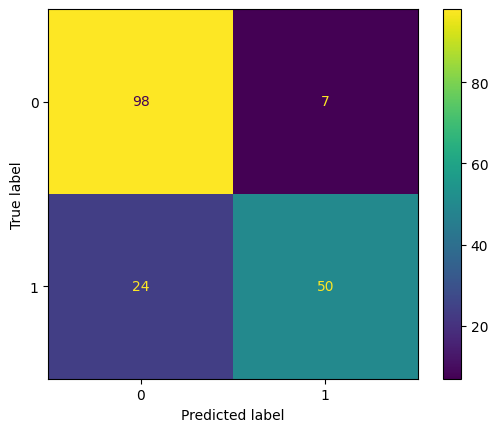

In [62]:
ConfusionMatrixDisplay.from_estimator(best_rf, xtest, ytest)

In [64]:
ypred_test_rf = best_rf.predict(xtest)

In [65]:
ypred_test_rf[0:5]

array([1, 0, 0, 0, 0])

In [66]:
ytest.head()

,Survived
617,0
379,0
725,0
826,0
450,0


In [63]:
from sklearn.metrics import classification_report

In [67]:
print(classification_report(ytest, ypred_test_rf))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       105
           1       0.88      0.68      0.76        74

    accuracy                           0.83       179
   macro avg       0.84      0.80      0.81       179
weighted avg       0.83      0.83      0.82       179



### Gradient Boost

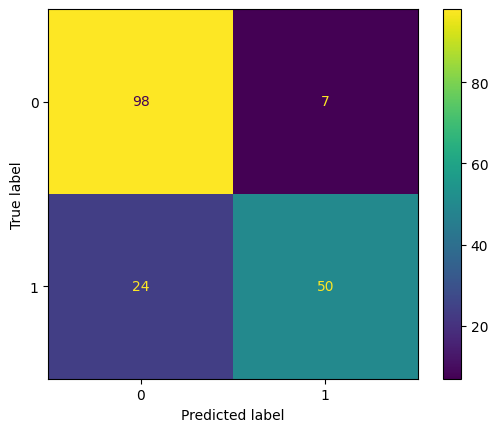

In [68]:
ConfusionMatrixDisplay.from_estimator(best_gb, xtest, ytest)

In [69]:
ypred_test_gb = best_gb.predict(xtest)

In [70]:
ypred_test_gb[0:5]

array([1, 0, 0, 0, 0])

In [72]:
ytest.head()

,Survived
617,0
379,0
725,0
826,0
450,0


In [73]:
print(classification_report(ytest, ypred_test_gb))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       105
           1       0.88      0.68      0.76        74

    accuracy                           0.83       179
   macro avg       0.84      0.80      0.81       179
weighted avg       0.83      0.83      0.82       179



### Both Random Forest and Gradient Boost are performing equally well 
### Here lets select Gradient Boost for out of sample prediction
### Because Gradient boost was slightly better in cv results

### Step 8 - Out of sample prediction

In [74]:
xnew = pd.read_csv("test_titanic.csv")
xnew.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [75]:
pre

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Sex', 'Embarked'])])

In [76]:
xnew_pre = pre.transform(xnew)
xnew_pre.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
0,0.827377,0.394887,-0.474545,-0.473674,-0.490783,0.0,1.0,0.0,1.0,0.0
1,0.827377,1.355510,0.432793,-0.473674,-0.507479,1.0,0.0,0.0,0.0,1.0
2,-0.369365,2.508257,-0.474545,-0.473674,-0.453367,0.0,1.0,0.0,1.0,0.0
3,0.827377,-0.181487,-0.474545,-0.473674,-0.474005,0.0,1.0,0.0,0.0,1.0
4,0.827377,-0.565736,0.432793,0.767630,-0.401017,1.0,0.0,0.0,0.0,1.0


In [77]:
preds = best_gb.predict(xnew_pre)
preds[0:5]

array([0, 1, 0, 0, 0])

In [81]:
best_gb.classes_

array([0, 1])

In [80]:
probs = best_gb.predict_proba(xnew_pre)
probs[0:5]

array([[0.87228323, 0.12771677],
       [0.44045159, 0.55954841],
       [0.86008124, 0.13991876],
       [0.89148598, 0.10851402],
       [0.55713023, 0.44286977]])

In [82]:
prob_sur = probs[:, 1]
prob_sur[0:5]

array([0.12771677, 0.55954841, 0.13991876, 0.10851402, 0.44286977])

### Save the results in new dataframe

In [84]:
res = xnew[["PassengerId"]]
res.head()

,PassengerId
0,892
1,893
2,894
3,895
4,896


In [85]:
res["Survived_pred"] = preds
res["Survived_prob"] = prob_sur

In [87]:
res = res.round(4)

In [88]:
res

,PassengerId,Survived_pred,Survived_prob
0,892,0,0.1277
1,893,1,0.5595
2,894,0,0.1399
3,895,0,0.1085
4,896,0,0.4429
...,...,...,...
413,1305,0,0.1085
414,1306,1,0.9397
415,1307,0,0.0876
416,1308,0,0.1085


In [89]:
res.to_csv("GBResults.csv", index=False)

In [90]:
res["Survived_pred"].value_counts()

Survived_pred
0    286
1    132
Name: count, dtype: int64

<Axes: xlabel='Survived_pred'>

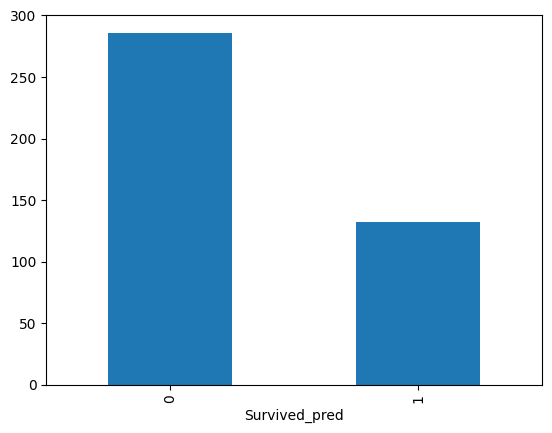

In [91]:
res["Survived_pred"].value_counts().plot(kind="bar")

### Feature Importances

In [93]:
imp = best_gb.feature_importances_
imp = pd.Series(imp, index=xtrain.columns)
imp

num__Pclass        0.151108
num__Age           0.132644
num__SibSp         0.032818
num__Parch         0.014874
num__Fare          0.106251
cat__Sex_female    0.257617
cat__Sex_male      0.279467
cat__Embarked_C    0.003322
cat__Embarked_Q    0.003739
cat__Embarked_S    0.018159
dtype: float64

In [94]:
imp.sort_values()

cat__Embarked_C    0.003322
cat__Embarked_Q    0.003739
num__Parch         0.014874
cat__Embarked_S    0.018159
num__SibSp         0.032818
num__Fare          0.106251
num__Age           0.132644
num__Pclass        0.151108
cat__Sex_female    0.257617
cat__Sex_male      0.279467
dtype: float64

<Axes: >

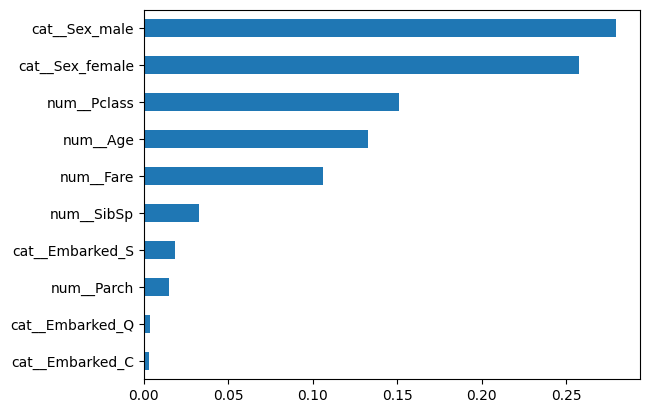

In [95]:
imp.sort_values().plot(kind="barh")